## Import & Data Load

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('/content/drive/MyDrive/hd/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/drive/MyDrive/hd/test.csv').drop(columns=['SAMPLE_ID'])
#train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
#test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train.shape

(367441, 26)

In [ ]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ATA                 367441 non-null  object 
 5   ID                  367441 non-null  object 
 6   BREADTH             367440 non-null  float64
 7   BUILT               367441 non-null  int64  
 8   DEADWEIGHT          367441 non-null  int64  
 9   DEPTH               367440 non-null  float64
 10  DRAUGHT             367440 non-null  float64
 11  GT                  367441 non-null  int64  
 12  LENGTH              367440 non-null  float64
 13  SHIPMANAGER         367441 non-null  object 
 14  FLAG                367441 non-null  object 
 15  U_WIND              213955 non-nul

In [ ]:
train.isnull().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ID                    0
BUILT                 0
DEPTH                 1
LENGTH                1
SHIPMANAGER           0
FLAG                  0
ATA_LT                0
WTI                   0
PORT_SIZE             0
CI_HOUR               0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
dtype: int64

## Data Pre-processing

In [79]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

for df in [train, test]:
  df.sort_values(by=['ATA'],inplace=True)
  df.set_index(df['ATA'],inplace=True)


# datetime을 여러 파생 변수로 변환

for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday



# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [ ]:
# test 결측치 처리 or train결측치 삭제
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

<ipython-input-80-49d3fdc3ba1b>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.fillna(train.mean(), inplace=True)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367441 entries, 2014-09-01 00:05:00 to 2023-02-28 14:55:00
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ID                  367441 non-null  object 
 5   BREADTH             367440 non-null  float64
 6   BUILT               367441 non-null  int64  
 7   DEADWEIGHT          367441 non-null  int64  
 8   DEPTH               367440 non-null  float64
 9   DRAUGHT             367440 non-null  float64
 10  GT                  367441 non-null  int64  
 11  LENGTH              367440 non-null  float64
 12  SHIPMANAGER         367441 non-null  object 
 13  FLAG                367441 non-null  object 
 14  U_WIND              213955 non-null  float64
 15  

In [ ]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
ATA,,,,,,,,,,,,,,,,,,,,,
2014-09-01 00:05:00,BR,VFD8,Bulk,0.000000,S736157,30.0,22,50300,20.0,10.0,...,95.96,1137.632567,0.000061,0.000000,2014,9,1,0,5,0
2014-09-01 00:05:00,ZA,CXL1,Bulk,49.910085,A876246,40.0,12,175000,20.0,20.0,...,95.54,1128.737090,0.000026,48.778889,2014,9,1,0,5,0
2014-09-01 00:05:00,ZA,CXL1,Bulk,0.000000,I488233,40.0,12,181000,20.0,20.0,...,95.96,1137.632567,0.000026,0.000000,2014,9,1,0,5,0
2014-09-01 00:12:00,BR,MMW5,Bulk,32.304726,G218822,30.0,13,56800,20.0,10.0,...,92.27,1167.284154,0.000051,265.620556,2014,9,1,0,12,0
2014-09-01 00:14:00,BR,VFD8,Bulk,0.000000,S763672,30.0,14,76600,20.0,10.0,...,95.96,1137.632567,0.000061,0.000000,2014,9,1,0,14,0


array([[<Axes: title={'center': 'DIST'}>,
        <Axes: title={'center': 'BREADTH'}>,
        <Axes: title={'center': 'BUILT'}>,
        <Axes: title={'center': 'DEADWEIGHT'}>,
        <Axes: title={'center': 'DEPTH'}>],
       [<Axes: title={'center': 'DRAUGHT'}>,
        <Axes: title={'center': 'GT'}>,
        <Axes: title={'center': 'LENGTH'}>,
        <Axes: title={'center': 'U_WIND'}>,
        <Axes: title={'center': 'V_WIND'}>],
       [<Axes: title={'center': 'AIR_TEMPERATURE'}>,
        <Axes: title={'center': 'BN'}>,
        <Axes: title={'center': 'ATA_LT'}>,
        <Axes: title={'center': 'DUBAI'}>,
        <Axes: title={'center': 'BRENT'}>],
       [<Axes: title={'center': 'WTI'}>,
        <Axes: title={'center': 'BDI_ADJ'}>,
        <Axes: title={'center': 'PORT_SIZE'}>,
        <Axes: title={'center': 'CI_HOUR'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center':

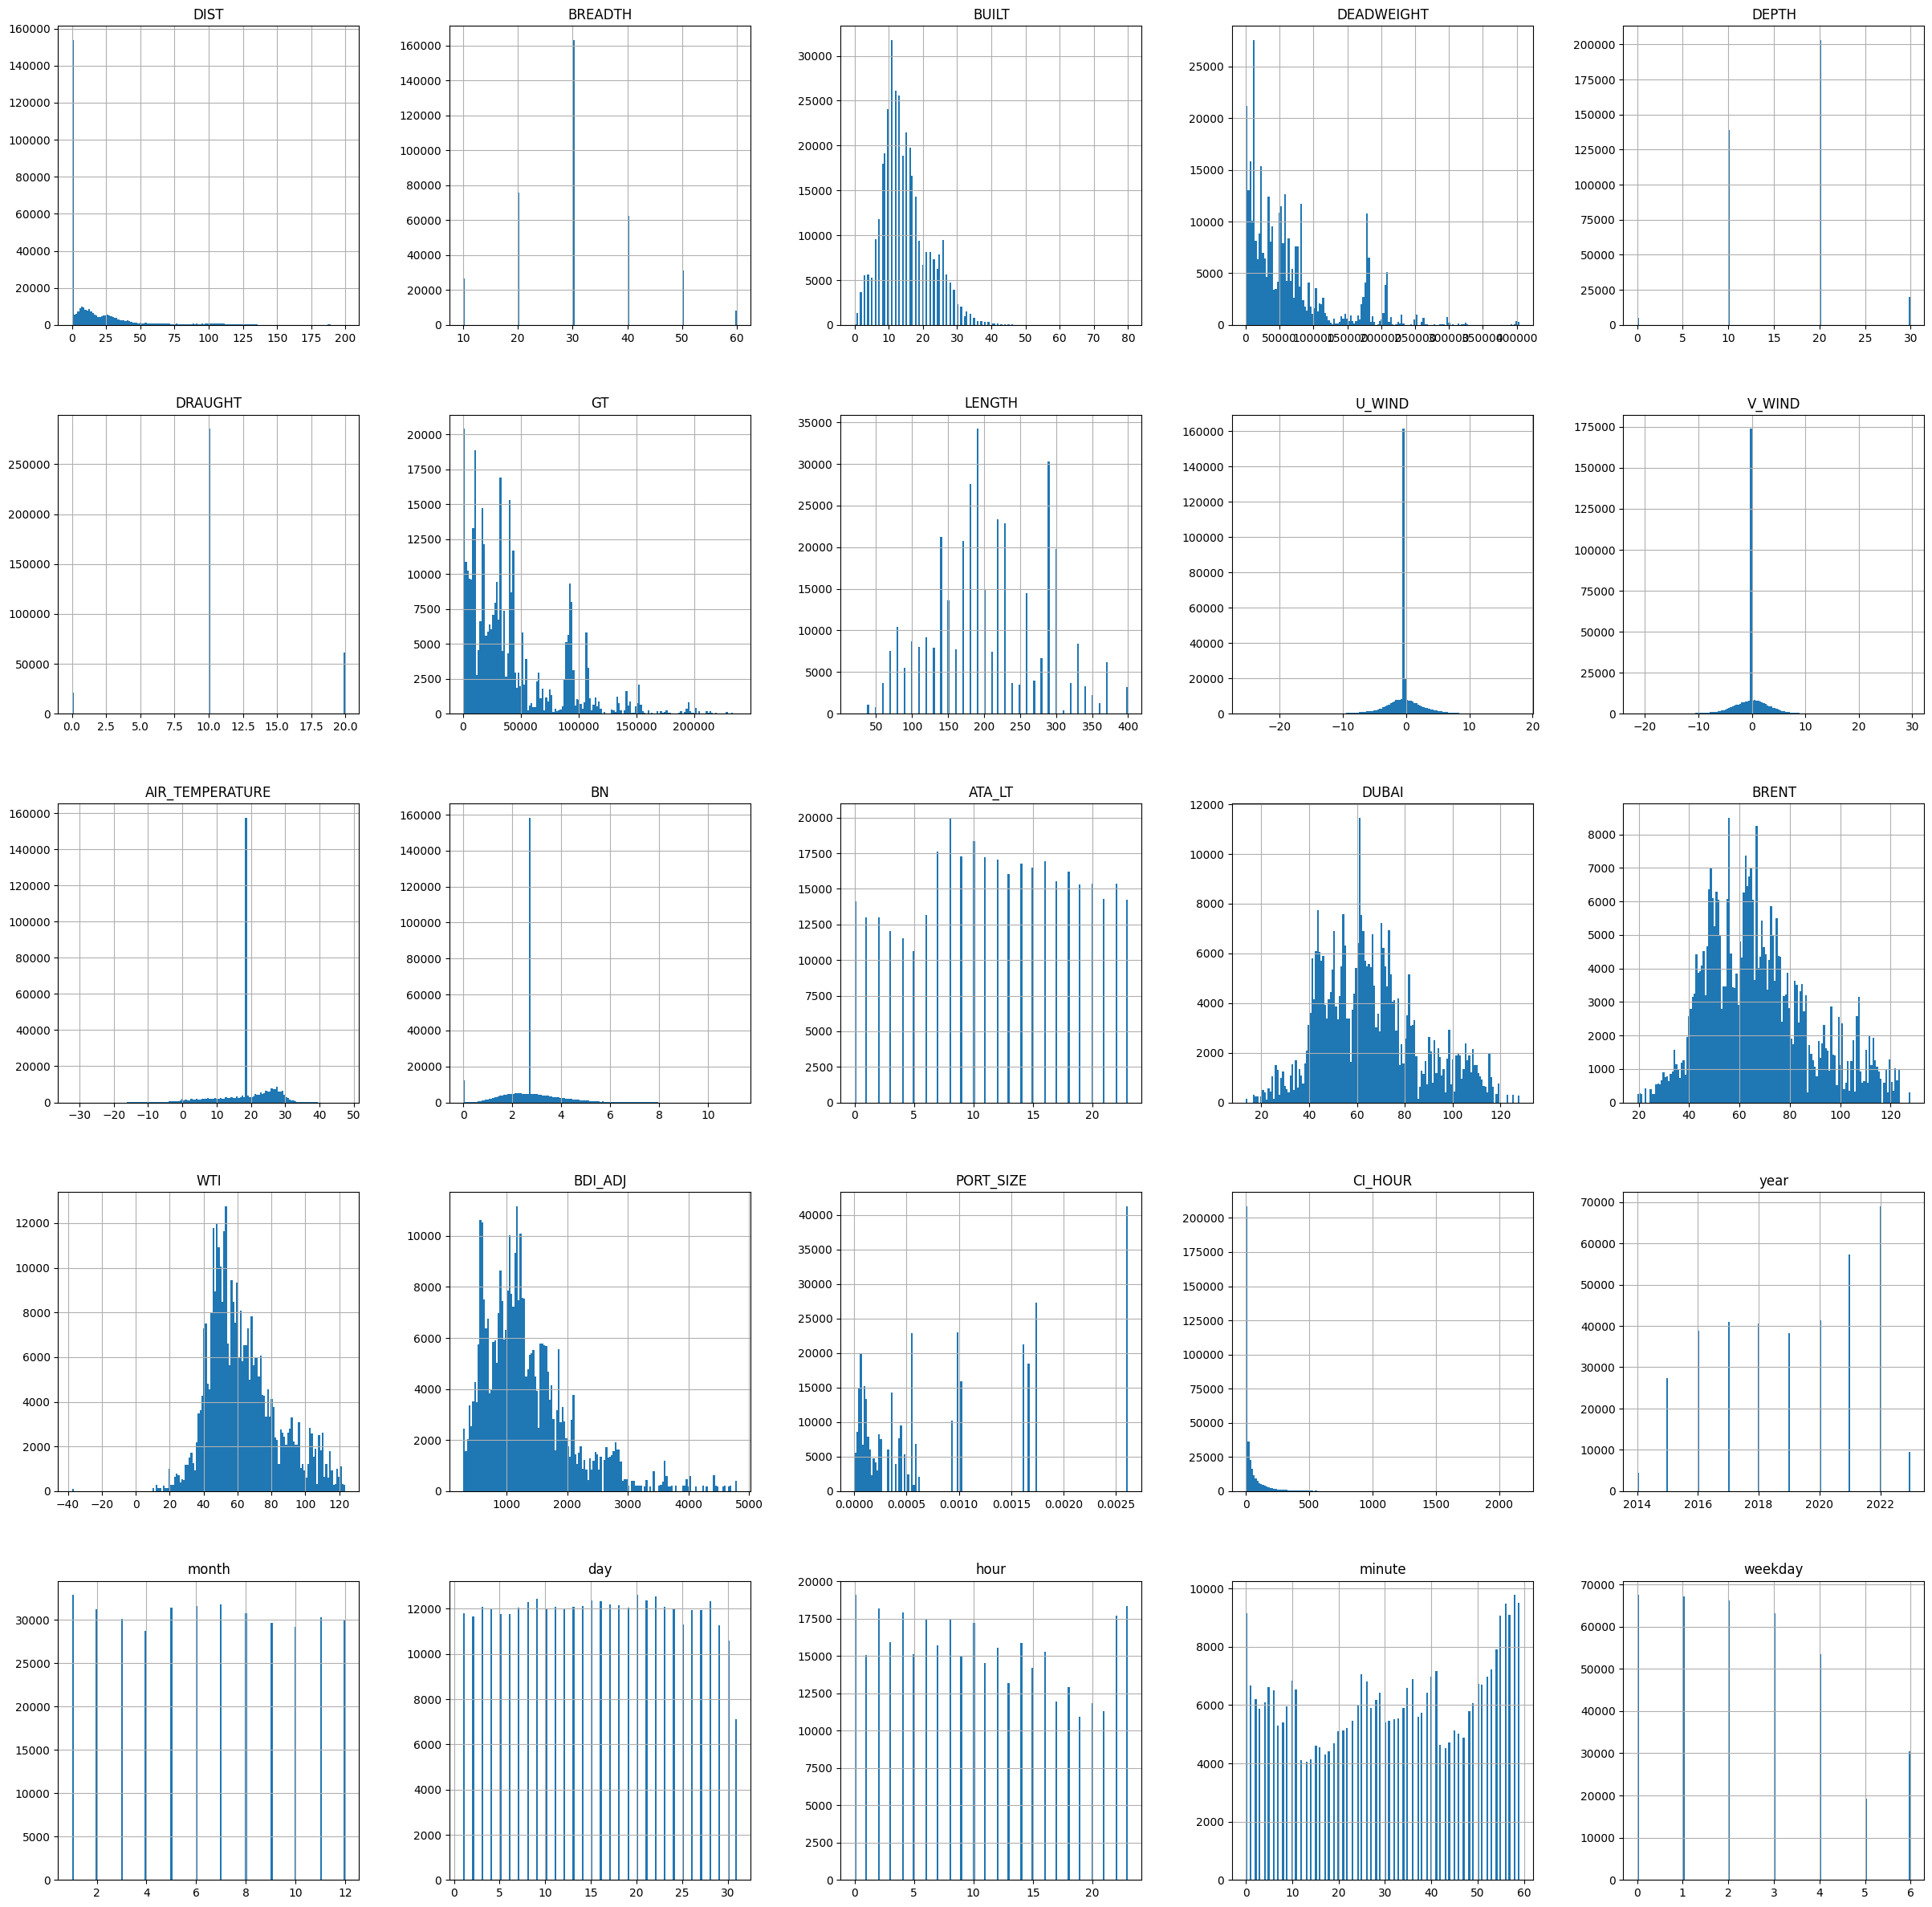

In [ ]:
train.hist(figsize=(30,30),bins = 150)


<ipython-input-14-664cfe00ac2b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = train.corr()


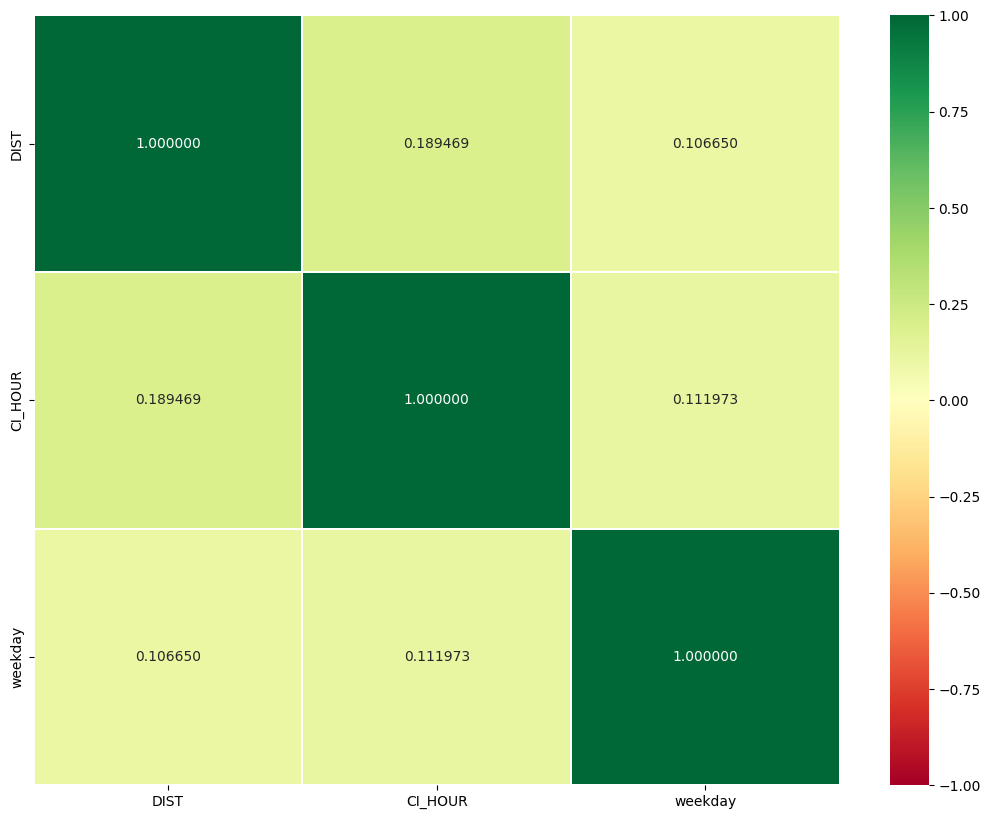

In [ ]:
import seaborn as sns
df_corr = train.corr()
top_corr_features = df_corr.index[abs(df_corr["CI_HOUR"])>=0.1]
top_corr_features
plt.figure(figsize=(13,10))
tp = sns.heatmap(train[top_corr_features].corr(),vmin=-1,vmax=1,linewidths=0.2,annot=True,fmt='f',cmap="RdYlGn")
plt.show()

<ipython-input-15-91b182253440>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tp = sns.heatmap(train.corr(),vmin=-1,vmax=1,linewidths=0.2,fmt='f',cmap="Blues")


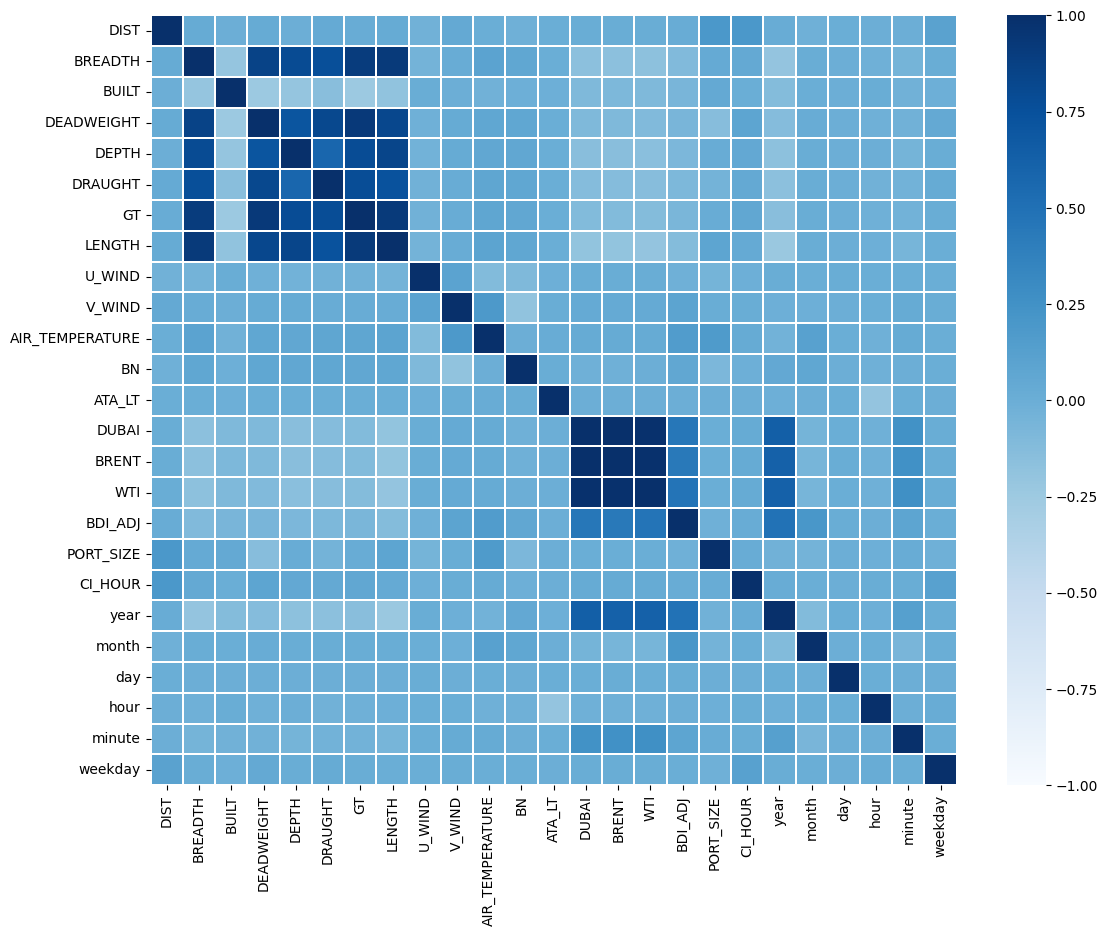

In [ ]:
plt.figure(figsize=(13,10))
tp = sns.heatmap(train.corr(),vmin=-1,vmax=1,linewidths=0.2,fmt='f',cmap="Blues")
plt.show()

In [ ]:
#DUBAI,BRENT,WTI 가 연관성이 깊으니 1개만 남기고 나머지 없앤다.
#LENGTH,GT,DRAUGHT,DEPTH,DEADWEIGHT,BREADTH가 연관성이 깊으니 1개만 남기고 나머지를 없앤다.
train = train.drop(columns=['BRENT','DUBAI','GT','DRAUGHT','DEADWEIGHT','BREADTH','BDI_ADJ'])
test = test.drop(columns=['BRENT','DUBAI','GT','DRAUGHT','DEADWEIGHT','BREADTH','BDI_ADJ'])

In [ ]:
train['dist_cut'] = 1
train.loc[train['DIST'] < 1,'dist_cut'] = 0
train.loc[train['DIST'] > 40,'dist_cut'] = 2
train.hist(column='CI_HOUR',by='dist_cut')


test['dist_cut'] = 1
test.loc[test['DIST'] < 1,'dist_cut'] = 0
test.loc[test['DIST'] > 40,'dist_cut'] = 2

#test.drop(['DIST'], axis=1, inplace=True)
#train.drop(['DIST'], axis=1, inplace=True)




In [ ]:
def make_category(v):
  v = (v//10)
  return v

train.insert(15,'built_cut',train.BUILT.apply(make_category))
train.hist(column='CI_HOUR',by='built_cut')

test.insert(15,'built_cut',test.BUILT.apply(make_category))



test.drop(['BUILT'], axis=1, inplace=True)
train.drop(['BUILT'], axis=1, inplace=True)

In [ ]:
def make_category2(v):
  v = (v//75)
  return v

train.insert(10,'length_cut',train.LENGTH.apply(make_category2))
train.hist(column='CI_HOUR',by='length_cut')


test.insert(10,'length_cut',test.LENGTH.apply(make_category2))


test.drop(['LENGTH'], axis=1, inplace=True)
train.drop(['LENGTH'], axis=1, inplace=True)

In [ ]:
def make_category3(v):
  v = (v//0.00025)
  return v

train.insert(10,'port_cut',train.PORT_SIZE.apply(make_category3))
train.hist(column='CI_HOUR',by='port_cut')


test.insert(10,'port_cut',test.PORT_SIZE.apply(make_category3))


test.drop(['PORT_SIZE'], axis=1, inplace=True)
train.drop(['PORT_SIZE'], axis=1, inplace=True)


In [ ]:
#train['u_wind_cut'] = 0
#train['v_wind_cut'] = 0
#train.loc[abs(train['U_WIND']) < 10,'u_wind_cut'] = 1
#train.loc[abs(train['V_WIND']) < 10,'v_wind_cut'] = 1
#train.hist(column='CI_HOUR',by='u_wind_cut')
#train.hist(column='CI_HOUR',by='v_wind_cut')
#train.hist(column='CI_HOUR')
#test['u_wind_cut'] = 0
#test['v_wind_cut'] = 0
#test.loc[abs(test['U_WIND']) < 10,'u_wind_cut'] = 1
#test.loc[abs(test['V_WIND']) < 10,'v_wind_cut'] = 1
test.drop(['U_WIND'], axis=1, inplace=True)
train.drop(['U_WIND'], axis=1, inplace=True)
test.drop(['V_WIND'], axis=1, inplace=True)
train.drop(['V_WIND'], axis=1, inplace=True)



#결측치가 많은 행이라 아예 열을 제거해도 괜찮을 수 있겠다.

In [ ]:
#train['air_cut'] = 1
#train.loc[train['AIR_TEMPERATURE'] < 0,'air_cut'] = 0
#train.loc[abs(train['AIR_TEMPERATURE']) > 30,'air_cut'] = 2
#train.groupby(['dist_cut']).hist(column='CI_HOUR',by='air_cut')


#test['air_cut'] = 1
#test.loc[test['AIR_TEMPERATURE'] < 0,'air_cut'] = 0
#test.loc[abs(test['AIR_TEMPERATURE']) > 30,'air_cut'] = 2

test.drop(['AIR_TEMPERATURE'], axis=1, inplace=True)
train.drop(['AIR_TEMPERATURE'], axis=1, inplace=True)


In [ ]:
train['bn_cut'] = 0
train.loc[train['BN'] <0.1,'bn_cut'] = 1
train.loc[train['BN'] > 6,'bn_cut'] = 2
train.groupby(['dist_cut']).hist(column='CI_HOUR',by='bn_cut')


test['bn_cut'] = 0
test.loc[test['BN'] <0.1,'bn_cut'] = 1
test.loc[test['BN'] > 6,'bn_cut'] = 2

test.drop(['BN'], axis=1, inplace=True)
train.drop(['BN'], axis=1, inplace=True)


In [ ]:
train.groupby(['dist_cut']).hist(column='CI_HOUR',by='ATA_LT')

In [ ]:
# 분포를 보면 WTI -40 인 데이터가 존재해 삭제하자.

idx = train[train['WTI']<=0].index
train.drop(idx,inplace=True)

train.insert(10,'wti_cut',train.WTI.apply(make_category))
train.hist(column='CI_HOUR',by='wti_cut')

test.insert(10,'wti_cut',test.WTI.apply(make_category))
train.drop(['WTI'],axis=1,inplace=True)
test.drop(['WTI'],axis=1,inplace=True)

In [ ]:
train['month_cut'] = 0
train.loc[train['month'] >3,'month_cut'] = 1
train.loc[train['month'] >7,'month_cut'] = 2
train.loc[train['month'] >10,'month_cut'] = 3
train.groupby(['dist_cut']).hist(column='CI_HOUR',by='month_cut')



test['month_cut'] = 0
test.loc[test['month'] >3,'month_cut'] = 1
test.loc[test['month'] >7,'month_cut'] = 2
test.loc[test['month'] >10,'month_cut'] = 3


In [ ]:
train.info()


In [ ]:
test.info()

In [ ]:
#train = train.astype({'port_cut':'int'})
#train = train.astype({'wti_cut':'int'})
#train = train.astype({'length_cut':'int'})
#train = train.astype({'DEPTH':'int'})

#test = test.astype({'port_cut':'int'})
#test = test.astype({'wti_cut':'int'})
#test = test.astype({'length_cut':'int'})
#test = test.astype({'DEPTH':'int'})

train['length_cut'] = train['length_cut'].astype('float')
train['length_cut'] = train['length_cut'].astype('int')



train.drop(['ARI_CO', 'SHIP_TYPE_CATEGORY','SHIPMANAGER','DEPTH','FLAG','ATA_LT',
                        'wti_cut','built_cut','port_cut','year','month','hour',
                       'day','minute','bn_cut'],axis=1,inplace=True)
test.drop(['ARI_CO', 'SHIP_TYPE_CATEGORY','SHIPMANAGER','DEPTH','FLAG','ATA_LT',
                        'wti_cut','built_cut','port_cut','year','month','hour',
                       'day','minute','bn_cut'],axis=1,inplace=True)


# Categorical 컬럼 인코딩
#categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY','ID','SHIPMANAGER','DEPTH','FLAG','length_cut','ATA_LT',
#                        'wti_cut','built_cut','port_cut','year','weekday','month','hour', 'dist_cut','month_cut',
#                        'day','minute']


categorical_features = ['ARI_PO','ID','dist_cut','weekday','length_cut','month_cut']


#'bn_cut','v_wind_cut','u_wind_cut','air_cut'

encoders = {}

for i in enumerate (categorical_features) :
    ca = i[1]
    train[ca] = train[ca].astype('category')
    test[ca] = test[ca].astype('category')

#for feature in tqdm(categorical_features, desc="Encoding features"):
#    le = LabelEncoder()
#    train[feature] = le.fit_transform(train[feature].astype(str))
#    le_classes_set = set(le.classes_)
#    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
#    le_classes = le.classes_.tolist()
#    bisect.insort_left(le_classes, '-1')
#    le.classes_ = np.array(le_classes)
#    test[feature] = le.transform(test[feature].astype(str))
#    encoders[feature] = le

In [ ]:
train.info()
test.info()




## 모델 학습 및 특성 중요도 확인

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,train_test_split

param_grid = {'learning_rate': 0.018272261776066247,
           'bagging_temperature': 63.512210106407046,
           'n_estimators': 3794,
           'max_depth': 11,
           'random_strength': 15,
           'colsample_bylevel': 0.49359671220172163,
           'l2_leaf_reg': 1.7519275289243016e-06,
           'min_child_samples': 88,
           'max_bin': 380,
           'od_type': 'IncToDec'
           }



X = train.drop(['CI_HOUR'],axis=1)
y = train['CI_HOUR']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cat_features = categorical_features
ensemble_predictions = []
scores = []


for train_idx, val_idx in tqdm(kf.split(X), total=5, desc="Processing folds"):
  X_t, X_val = X.iloc[train_idx], X.iloc[val_idx]
  y_t, y_val = y[train_idx], y[val_idx]

  cat = CatBoostRegressor(**param_grid)
  cat.fit(X_t, y_t,
          eval_set=[(X_t, y_t), (X_val,y_val)],
          early_stopping_rounds=5,cat_features=cat_features,
          verbose=100)
  val_pred = cat.predict(X_val)
  scores.append(mean_absolute_error(y_val, val_pred))
  cat_pred = cat.predict(test)
  cat_pred = np.where(cat_pred < 0, 0, cat_pred)
  ensemble_predictions .append(cat_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.124037
0:	learn: 164.1303664	test: 164.1395493	test1: 162.5168239	best: 162.5168239 (0)	total: 346ms	remaining: 5m 46s
100:	learn: 148.9441252	test: 148.6958209	test1: 147.3111469	best: 147.3111469 (100)	total: 27.5s	remaining: 4m 4s
200:	learn: 147.5017413	test: 147.2902574	test1: 146.3478148	best: 146.3478148 (200)	total: 51.1s	remaining: 3m 22s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 146.1925591
bestIteration = 249

Shrink model to first 250 iterations.


Processing folds:  20%|██        | 1/5 [01:09<04:38, 69.57s/it]

Learning rate set to 0.124037
0:	learn: 163.8662249	test: 163.9303762	test1: 163.6023667	best: 163.6023667 (0)	total: 416ms	remaining: 6m 55s
100:	learn: 148.7023640	test: 148.5285559	test1: 148.3755932	best: 148.3755932 (100)	total: 30.5s	remaining: 4m 31s
200:	learn: 147.5618013	test: 147.4904316	test1: 147.5428640	best: 147.5428640 (200)	total: 1m 4s	remaining: 4m 16s
300:	learn: 146.6887062	test: 146.6734376	test1: 146.9709004	best: 146.9704344 (298)	total: 1m 30s	remaining: 3m 30s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 146.7841836
bestIteration = 336

Shrink model to first 337 iterations.


Processing folds:  40%|████      | 2/5 [02:54<04:31, 90.52s/it]

Learning rate set to 0.124037
0:	learn: 163.6766471	test: 163.7413239	test1: 164.5861509	best: 164.5861509 (0)	total: 759ms	remaining: 12m 38s
100:	learn: 148.2195635	test: 147.9419222	test1: 149.9428309	best: 149.9428309 (100)	total: 27.4s	remaining: 4m 3s
200:	learn: 147.0082907	test: 146.9632951	test1: 149.2491275	best: 149.2491275 (200)	total: 50.8s	remaining: 3m 22s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 149.024155
bestIteration = 225

Shrink model to first 226 iterations.


Processing folds:  60%|██████    | 3/5 [03:54<02:33, 76.60s/it]

Learning rate set to 0.124037
0:	learn: 163.8306218	test: 163.8366799	test1: 163.1134971	best: 163.1134971 (0)	total: 786ms	remaining: 13m 4s
100:	learn: 148.8896723	test: 148.5379802	test1: 148.2913126	best: 148.2907958 (99)	total: 27.7s	remaining: 4m 6s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 147.2917843
bestIteration = 182

Shrink model to first 183 iterations.


Processing folds:  80%|████████  | 4/5 [04:55<01:10, 70.20s/it]

Learning rate set to 0.124037
0:	learn: 163.3236477	test: 163.3314275	test1: 165.1247813	best: 165.1247813 (0)	total: 415ms	remaining: 6m 54s
100:	learn: 148.0449458	test: 147.7300190	test1: 150.3365972	best: 150.3365972 (100)	total: 23.8s	remaining: 3m 31s
200:	learn: 146.7186466	test: 146.4543978	test1: 149.4255289	best: 149.4255289 (200)	total: 58.2s	remaining: 3m 51s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 149.2589538
bestIteration = 233

Shrink model to first 234 iterations.


Processing folds: 100%|██████████| 5/5 [06:09<00:00, 73.83s/it]

Validation : MAE scores for each fold: [55.530978743393106, 54.76638935724476, 55.902813946389315, 55.74907497517318, 55.97255763272871]
Validation : MAE: 55.58436293098581


## Submission

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/hd/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)